#   IDRIS 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
import numpy as np  
import pandas as pd 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     
%matplotlib inline

# Lets download our dataset we will be using

In [3]:
# First lets define transform
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform= transform)

In [5]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_loader = DataLoader(train_data, batch_size= 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size= 10, shuffle=False)

# Now breaking down Convolutional Neural Network (For Better Understadning)

In [9]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [10]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [11]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [12]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [13]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [14]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [15]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [16]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


# Ok so we have better understanding that what is happening inside CNN, Now lets define class for CNN model.

In [17]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [18]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
# This was copied
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [20]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


We can see that we half a total half less parameters from ANN, When using CNN.

In [21]:
# Defining loss and criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model

In [22]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.12040588  accuracy:  77.033%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.07601069  accuracy:  84.983%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.20449105  accuracy:  88.422%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.05690254  accuracy:  90.083%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.04506849  accuracy:  91.233%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00102738  accuracy:  92.156%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.07767428  accuracy:  92.829%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.01679319  accuracy:  93.356%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.67254341  accuracy:  93.824%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.43982148  accuracy:  94.168%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.60083187  accuracy:  97.350%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00697334  accuracy:  97.558%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00148123  accuracy:  97.811%
epoch:  1  b

As we can the accuracy is around 99%.

In [23]:
torch.save(model.state_dict(),'MNIST with CNN.pt')

Lets try a new image

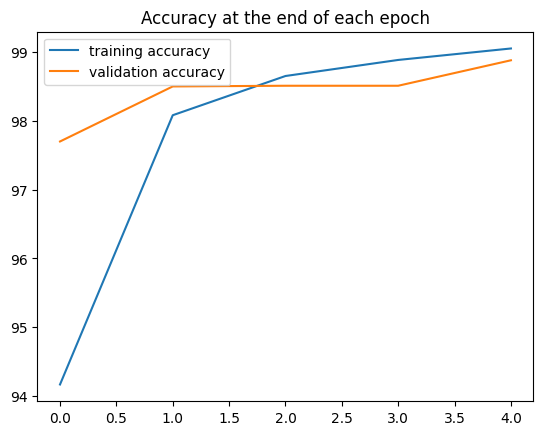

In [26]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Model Evaluation

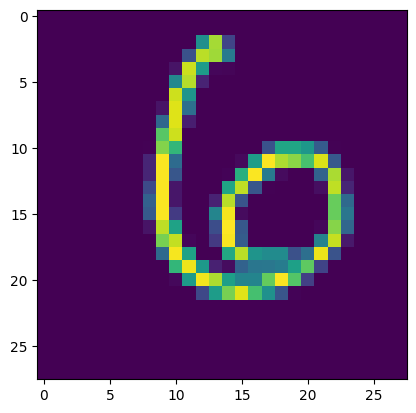

In [24]:
plt.imshow(test_data[100][0].reshape((28,28)))

In [25]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[100][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 6
